## Modeling Tuning Notebook:

Application of GridSearchCV, regularization and parameter tuning on selected models


Finetune the two selected models Random Forest and XGBoost, one after each other. 


=== Training and tuning: Random Forest ===
Optimal threshold selected: 0.70 (Precision=0.622, F1=0.279)


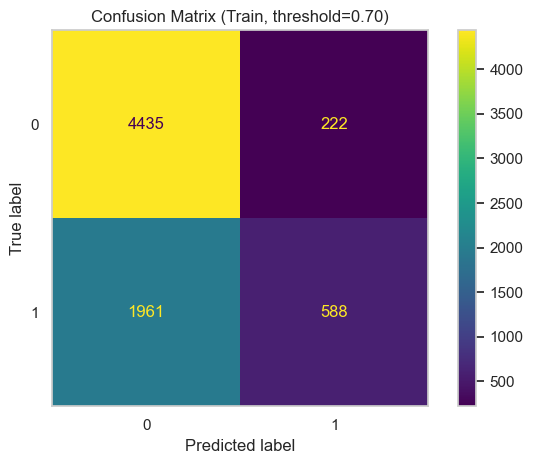

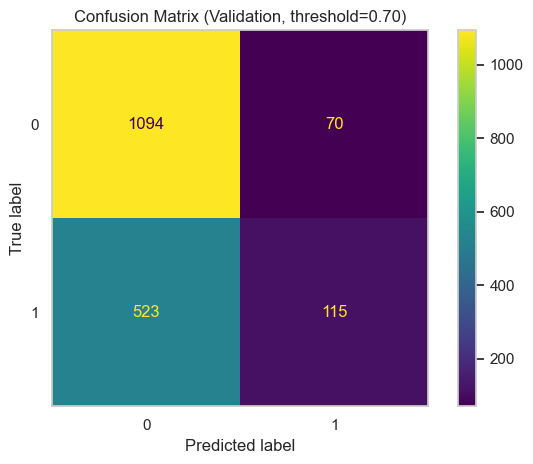

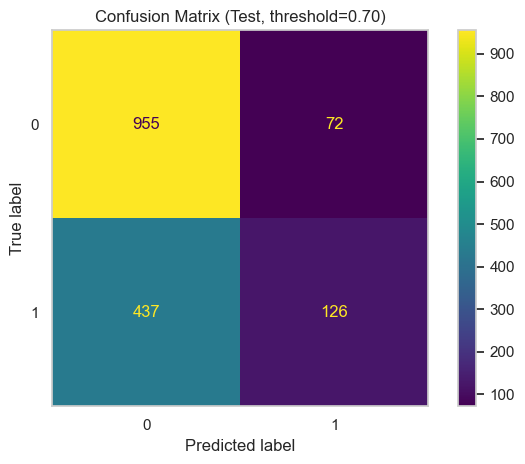

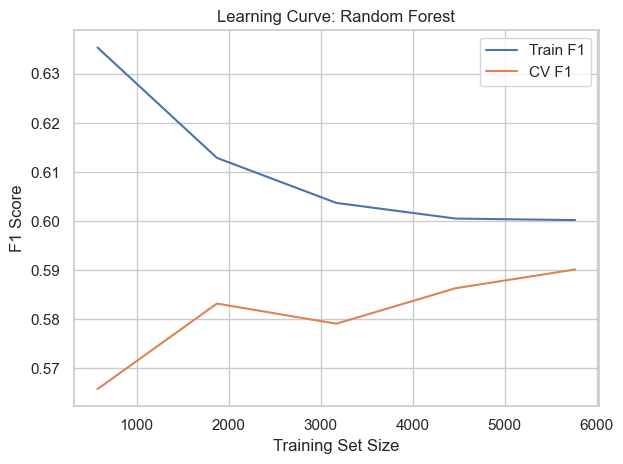

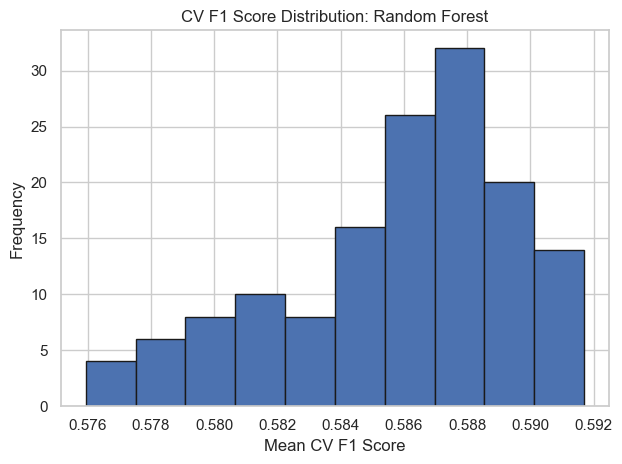

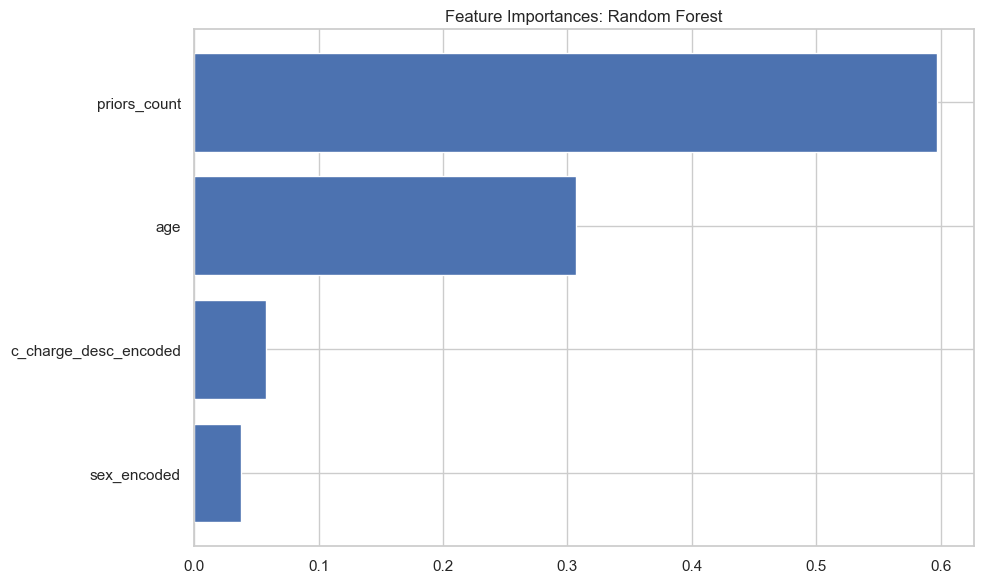

,Set,Threshold,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,0.7,0.697,0.726,0.231,0.350,0.738
1,Validation,0.7,0.671,0.622,0.180,0.279,0.702
2,Test,0.7,0.680,0.636,0.224,0.331,0.718


In [ ]:

# === RANDOM FOREST EVALUATION & TUNING ===

import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, learning_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# === Load Data ===
# Load cleaned dataset
df = pd.read_csv("../data/cox-violent-preprocessed.csv")

# Features and target
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

low_info_features = ["c_charge_degree_encoded", "juv_misd_count", "juv_fel_count"]
X = df.drop(["is_recid"] + low_info_features, axis=1)
y = df["is_recid"]

# === Train/Val/Test Split ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# === CV and Pipeline Setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "Random Forest": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5, 7],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [5, 10, 20],
        "clf__max_features": ['sqrt', 0.3], #reduced from ['sqrt', 0.3],
        "clf__bootstrap": [True, False]
    }
}

pipelines = {
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))
    ])
}

os.makedirs("../models", exist_ok=True)
os.makedirs("../reports", exist_ok=True)

thresholds = np.linspace(0.60, 0.70, 11)  # 0.60, 0.61, ..., 0.70
evaluation_results = []

for name, pipeline in pipelines.items():
    print(f"\n=== Training and tuning: {name} ===")

    #=== Apply SMOTE on training data ===
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # === Grid Search on oversampled data ===
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring=make_scorer(f1_score),
        cv=cv,
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    # grid_search.fit(X_train_smote, y_train_smote)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # === Save Model and Params ===
    joblib.dump(best_model, f"../models/{name.lower().replace(' ', '_')}_finetuned.pkl")
    with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
        json.dump(grid_search.best_params_, f, indent=2)

    pd.DataFrame(grid_search.cv_results_).to_csv(
        f"../reports/gridsearch_results_{name.lower().replace(' ', '_')}.csv", index=False
    )

    # === Threshold tuning on validation set ===
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    threshold_metrics = []
    for t in thresholds:
        y_pred = (y_val_proba >= t).astype(int)
        precision = precision_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        threshold_metrics.append({"Threshold": t, "Precision": precision, "F1": f1})
    threshold_df = pd.DataFrame(threshold_metrics)
    best_row = threshold_df.loc[threshold_df["Precision"].idxmax()]
    best_threshold = best_row["Threshold"]
    print(f"Optimal threshold selected: {best_threshold:.2f} (Precision={best_row['Precision']:.3f}, F1={best_row['F1']:.3f})")

    # === Evaluation function with threshold ===
    def evaluate_with_threshold(X_data, y_true, set_name):
        y_proba = best_model.predict_proba(X_data)[:, 1]
        y_pred = (y_proba >= best_threshold).astype(int)

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_proba)
        cm = confusion_matrix(y_true, y_pred)

        # Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot()
        plt.title(f"Confusion Matrix ({set_name}, threshold={best_threshold:.2f})")
        plt.grid(False)
        plt.tight_layout()
        plt.savefig(f"../reports/conf_matrix_threshold_{set_name.lower()}.png")
        plt.show()

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=["No Recidivism", "Recidivism"])
        with open(f"../reports/classification_report_threshold_{set_name.lower()}.txt", "w") as f:
            f.write(report)

        return {
            "Set": set_name,
            "Threshold": best_threshold,
            "Accuracy": round(acc, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1 Score": round(f1, 3),
            "AUC": round(auc, 3)
        }

    evaluation_results.append(evaluate_with_threshold(X_train, y_train, "Train"))
    evaluation_results.append(evaluate_with_threshold(X_val, y_val, "Validation"))
    evaluation_results.append(evaluate_with_threshold(X_test, y_test, "Test"))

    # === Learning Curve ===
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=cv,
        scoring="f1", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, label="Train F1")
    plt.plot(train_sizes, val_mean, label="CV F1")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve: {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../reports/learning_curve_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # === CV Score Histogram ===
    cv_scores = grid_search.cv_results_['mean_test_score']
    plt.figure()
    plt.hist(cv_scores, bins=10, edgecolor="k")
    plt.title(f"CV F1 Score Distribution: {name}")
    plt.xlabel("Mean CV F1 Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"../reports/cv_score_distribution_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # === Feature Importances ===
    if hasattr(best_model.named_steps["clf"], "feature_importances_"):
        importances = best_model.named_steps["clf"].feature_importances_
        feature_names = X.columns
        importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["Feature"], importance_df["Importance"])
        plt.title(f"Feature Importances: {name}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"../reports/feature_importance_{name.lower().replace(' ', '_')}.png")
        plt.show()

        importance_df.to_csv(f"../reports/feature_importances_{name.lower().replace(' ', '_')}.csv", index=False)

# === Save final threshold-evaluated metrics ===
eval_df = pd.DataFrame(evaluation_results)
eval_df.to_csv("../reports/threshold_tuned_randomforest_metrics.csv", index=False)

eval_df





Training and tuning: XGBoost


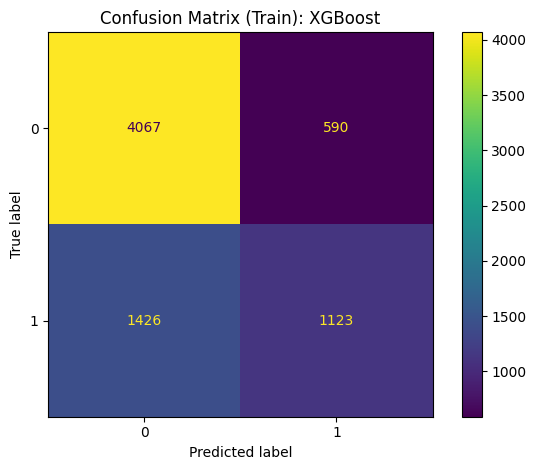

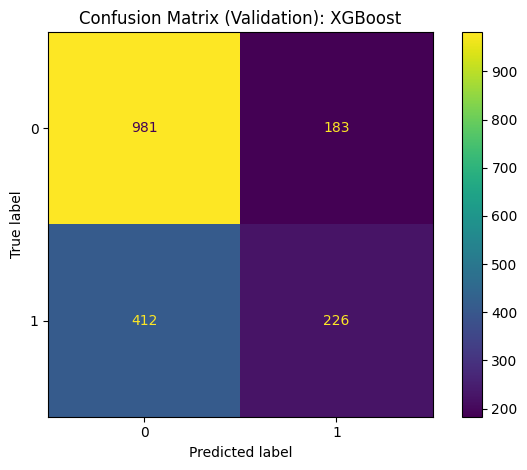

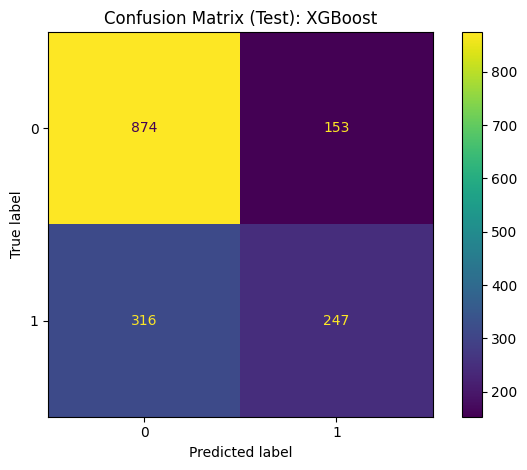

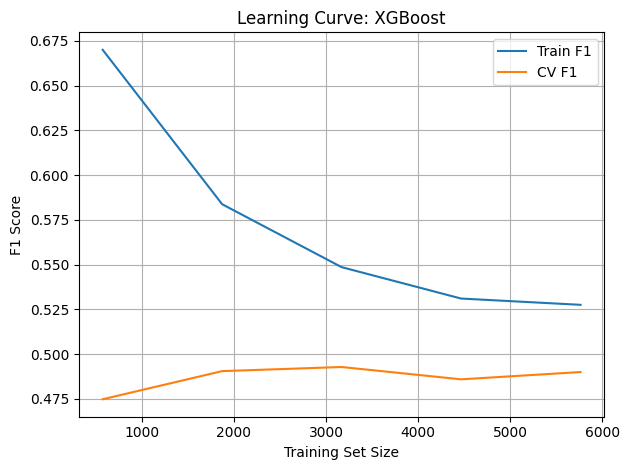

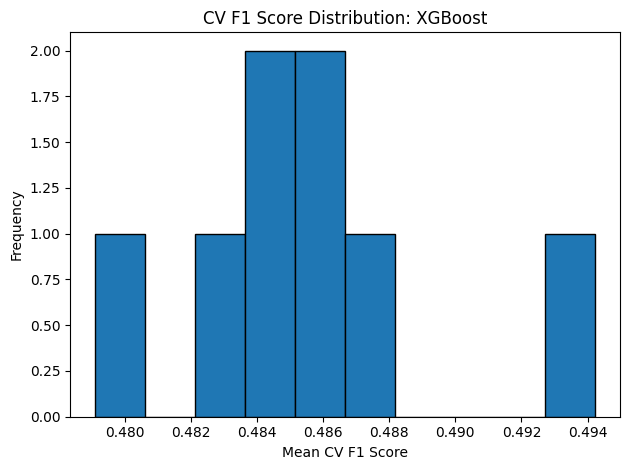

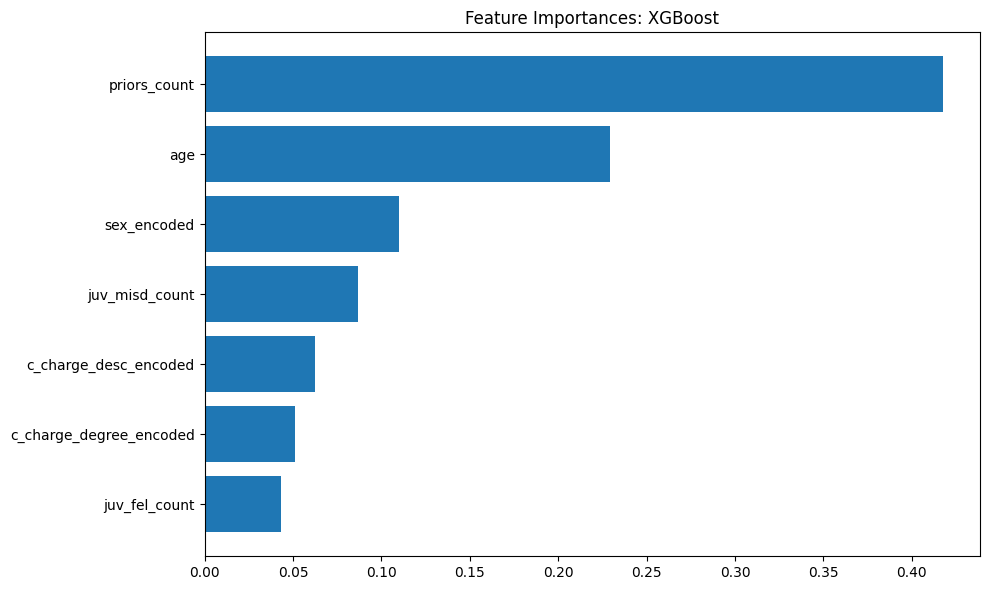

,Set,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,XGBoost,0.720,0.656,0.441,0.527,0.749
1,Validation,XGBoost,0.670,0.553,0.354,0.432,0.708
2,Test,XGBoost,0.705,0.618,0.439,0.513,0.724


In [ ]:
# === XGBOOST EVALUATION & TUNING ===

import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# === Load Data ===
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# === Train/Val/Test Split ===
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)

# === Cross-validation setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#=== Pipeline & Param Grid Original ===
param_grids = {
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3],
        # "clf__scale_pos_weight": [1, 2, 3], #this is the critical parameter to increase F1, but Precision will drop
        # "clf__gamma": [0, 1],
        # "clf__subsample": [0.8, 1.0],
        # "clf__colsample_bytree": [0.8, 1.0]
    }
}

pipelines = {
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ])
}

scorer = make_scorer(f1_score)

os.makedirs("../reports", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# === Run GridSearchCV ===
best_estimators_xg = {}
# thresholds = np.linspace(0.50, 0.70, 21)  # e.g., 0.50, 0.51, ..., 0.70 - might help to increase F1!

for name, pipeline in pipelines.items():
    print(f"Training and tuning: {name}")
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_estimators_xg[name] = best_model

    # Save model and best params
    joblib.dump(best_model, f"../models/{name.lower().replace(' ', '_')}_finetuned.pkl")
    with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
        json.dump(grid_search.best_params_, f, indent=2)

    pd.DataFrame(grid_search.cv_results_).to_csv(
        f"../reports/gridsearch_results_{name.lower().replace(' ', '_')}.csv", index=False
    )

    # === Evaluation on Train / Val / Test ===
    def evaluate_set(X_data, y_data, set_name):
        y_pred = best_model.predict(X_data)
        y_proba = best_model.predict_proba(X_data)[:, 1]

        acc = accuracy_score(y_data, y_pred)
        prec = precision_score(y_data, y_pred)
        rec = recall_score(y_data, y_pred)
        f1 = f1_score(y_data, y_pred)
        auc = roc_auc_score(y_data, y_proba)
        cm = confusion_matrix(y_data, y_pred)

        # Save confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot()
        plt.title(f"Confusion Matrix ({set_name}): {name}")
        plt.grid(False)
        plt.tight_layout()
        plt.savefig(f"../reports/confusion_matrix_{set_name.lower()}_{name.lower().replace(' ', '_')}.png")
        plt.show()

        # Save classification report
        report = classification_report(y_data, y_pred, target_names=["No Recidivism", "Recidivism"])
        with open(f"../reports/classification_report_{set_name.lower()}_{name.lower().replace(' ', '_')}.txt", "w") as f:
            f.write(report)

        return {
            "Set": set_name,
            "Model": name,
            "Accuracy": round(acc, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1 Score": round(f1, 3),
            "AUC": round(auc, 3)
        }

    evaluation_results = []
    evaluation_results.append(evaluate_set(X_train, y_train, "Train"))
    evaluation_results.append(evaluate_set(X_val, y_val, "Validation"))
    evaluation_results.append(evaluate_set(X_test, y_test, "Test"))

    # Save metrics
    eval_df = pd.DataFrame(evaluation_results)
    eval_df.to_csv(f"../reports/tuned_{name.lower().replace(' ', '_')}_model_metrics_summary.csv", index=False)

    # === Learning Curve ===
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=cv,
        scoring="f1", n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=True, random_state=42
    )
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train F1")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="CV F1")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve: {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../reports/learning_curve_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # === CV Score Distribution ===
    cv_scores = grid_search.cv_results_["mean_test_score"]
    plt.figure()
    plt.hist(cv_scores, bins=10, edgecolor="k")
    plt.title(f"CV F1 Score Distribution: {name}")
    plt.xlabel("Mean CV F1 Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"../reports/cv_score_distribution_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # === Feature Importances (from XGBoost) ===
    importances = best_model.named_steps["clf"].feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.title(f"Feature Importances: {name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"../reports/feature_importance_{name.lower().replace(' ', '_')}.png")
    plt.show()

    importance_df.to_csv(f"../reports/feature_importances_{name.lower().replace(' ', '_')}.csv", index=False)

# Final summary
eval_df


Evaluate and tune baseline model:

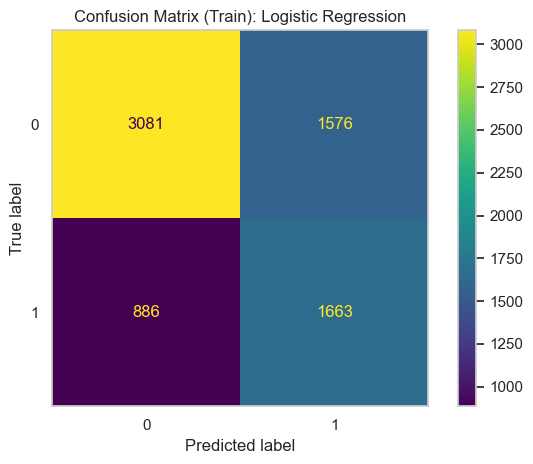

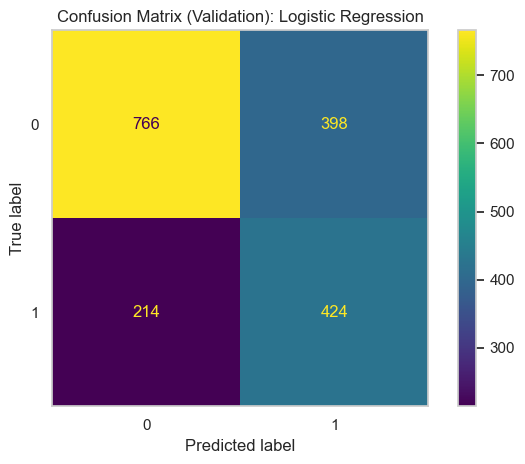

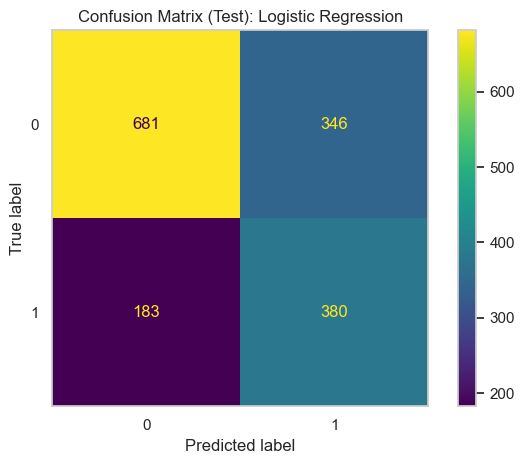

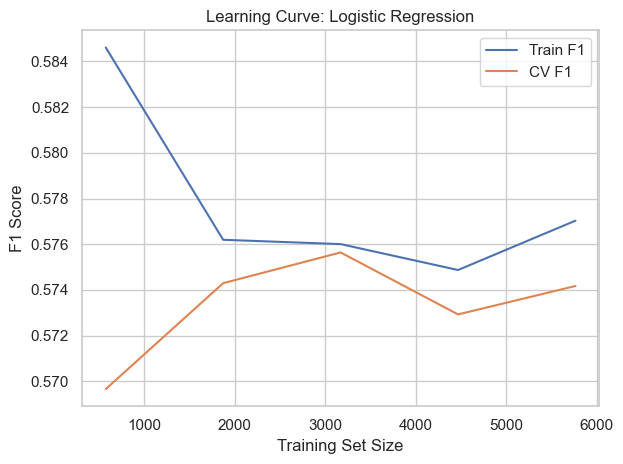

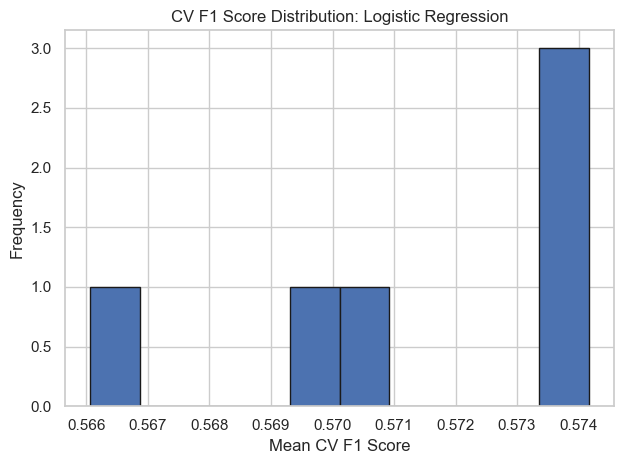

,Set,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,Logistic Regression,0.658,0.513,0.652,0.575,0.712
1,Validation,Logistic Regression,0.660,0.516,0.665,0.581,0.704
2,Test,Logistic Regression,0.667,0.523,0.675,0.590,0.706


In [ ]:
# === BASELINE MODEL LOGISTIC REGRESSION EVALUATION & TUNING === 

import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve

# === Load Data ===
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# === Split Data ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# === Cross-validation setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"))
])

logreg_param_grid = {
    "clf__C": [0.001, 0.005, 0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

scorer = make_scorer(f1_score)
os.makedirs("../reports", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# === Train with GridSearchCV ===
name = "Logistic Regression"
grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=True
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

joblib.dump(best_model, f"../models/{name.lower().replace(' ', '_')}_finetuned.pkl")
with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
    json.dump(grid_search.best_params_, f, indent=2)

pd.DataFrame(grid_search.cv_results_).to_csv(
    f"../reports/gridsearch_results_{name.lower().replace(' ', '_')}.csv", index=False
)

# === Threshold tuning ===
thresholds = np.linspace(0.50, 0.75, 26)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

threshold_results = []
for t in thresholds:
    y_pred_thresh = (y_val_proba >= t).astype(int)
    prec = precision_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)
    threshold_results.append({"Threshold": t, "Precision": prec, "F1": f1})

threshold_df = pd.DataFrame(threshold_results)
best_row = threshold_df.loc[threshold_df["Precision"].idxmax()]  # prioritize Precision
best_threshold = best_row["Threshold"]
print(f"Best threshold selected: {best_threshold:.2f} (Precision={best_row['Precision']:.3f}, F1={best_row['F1']:.3f})")

# === Evaluation Function ===
def evaluate_thresholded(X_data, y_data, set_name):
    y_proba = best_model.predict_proba(X_data)[:, 1]
    y_pred = (y_proba >= best_threshold).astype(int)

    acc = accuracy_score(y_data, y_pred)
    prec = precision_score(y_data, y_pred)
    rec = recall_score(y_data, y_pred)
    f1 = f1_score(y_data, y_pred)
    auc = roc_auc_score(y_data, y_proba)
    cm = confusion_matrix(y_data, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix ({set_name}, threshold={best_threshold:.2f})")
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"../reports/conf_matrix_threshold_{set_name.lower()}_{name.lower().replace(' ', '_')}.png")
    plt.close()

    report = classification_report(y_data, y_pred, target_names=["No Recidivism", "Recidivism"])
    with open(f"../reports/classification_report_threshold_{set_name.lower()}_{name.lower().replace(' ', '_')}.txt", "w") as f:
        f.write(report)

    return {
        "Set": set_name,
        "Model": name,
        "Threshold": best_threshold,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    }

# Evaluate on all sets
eval_results = []
eval_results.append(evaluate_thresholded(X_train, y_train, "Train"))
eval_results.append(evaluate_thresholded(X_val, y_val, "Validation"))
eval_results.append(evaluate_thresholded(X_test, y_test, "Test"))

# Save metrics
eval_df = pd.DataFrame(eval_results)
eval_df.to_csv(f"../reports/threshold_tuned_{name.lower().replace(' ', '_')}_balanced_metrics.csv", index=False)


# === Learning Curve ===
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=cv,
    scoring="f1", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True, random_state=42
)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train F1")
plt.plot(train_sizes, val_scores.mean(axis=1), label="CV F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title(f"Learning Curve: {name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../reports/learning_curve_{name.lower().replace(' ', '_')}.png")
plt.show()

# === CV Score Distribution ===
cv_scores = grid_search.cv_results_["mean_test_score"]
plt.figure()
plt.hist(cv_scores, bins=10, edgecolor="k")
plt.title(f"CV F1 Score Distribution: {name}")
plt.xlabel("Mean CV F1 Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(f"../reports/cv_score_distribution_{name.lower().replace(' ', '_')}.png")
plt.show()

# === Final Output ===
eval_df


Create illustrations of the regularization and tuning improvements for all models:

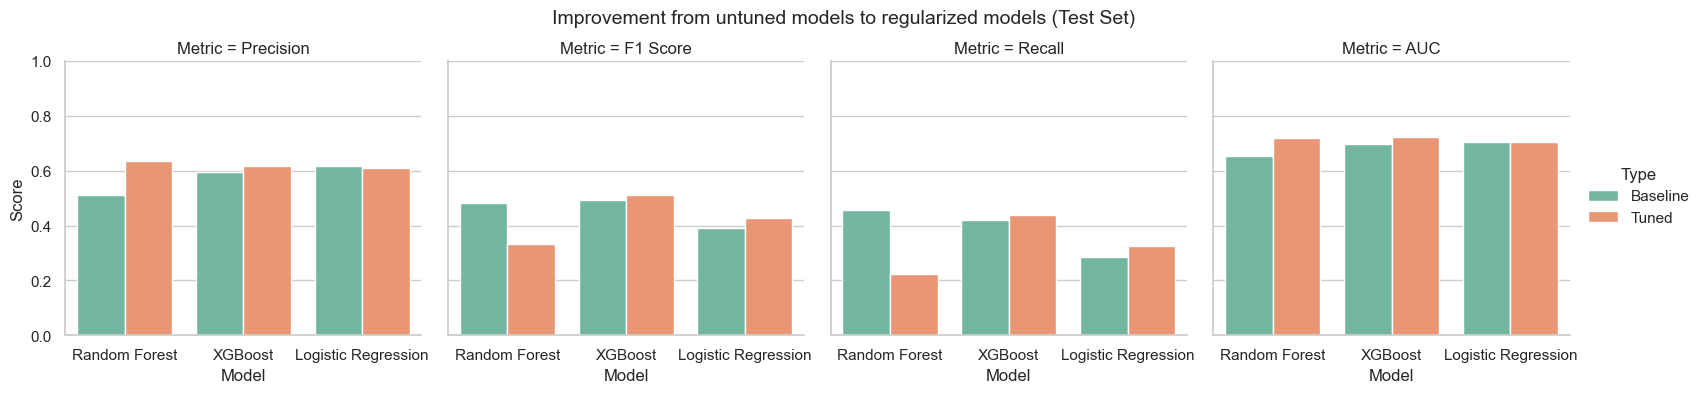

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# === Load tuned results ===
sorted_df = pd.read_csv("../reports/final_model_comparison.csv")
tuned_df = sorted_df[sorted_df["Set"] == "Test"].copy()
tuned_df["Type"] = "Tuned"

# Only keep required columns
tuned_df = tuned_df[["Model", "Type", "Precision", "Recall", "F1 Score", "AUC"]]

# === Simulate baselines with default settings ===
# Assume you already have X_train, y_train, X_test, y_test available in memory
def evaluate_baseline(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
        "Model": model_name,
        "Type": "Baseline",
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    }

baseline_results = []

# Random Forest (default)
baseline_results.append(evaluate_baseline(
    Pipeline([("clf", RandomForestClassifier(random_state=42))]),
    "Random Forest"
))

# XGBoost (default)
baseline_results.append(evaluate_baseline(
    Pipeline([("clf", XGBClassifier(eval_metric="logloss", random_state=42))]),
    "XGBoost"
))

# Logistic Regression (needs scaling)
baseline_results.append(evaluate_baseline(
    Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Logistic Regression"
))

baseline_df = pd.DataFrame(baseline_results)

# === Combine into improvement_df ===
improvement_df = pd.concat([baseline_df, tuned_df], ignore_index=True)

# === Melt for plotting ===
melted = improvement_df.melt(
    id_vars=["Model", "Type"], 
    value_vars=["Precision", "F1 Score", "Recall", "AUC"],
    var_name="Metric", 
    value_name="Score"
)

# === Plot ===
sns.set(style="whitegrid")

g = sns.catplot(
    data=melted,
    x="Model",
    y="Score",
    hue="Type",
    col="Metric",
    kind="bar",
    palette="Set2",
    height=4,
    aspect=1,
    errorbar=None  # replaces ci=None
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Improvement from untuned models to regularized models (Test Set)", fontsize=14)
g.set_axis_labels("Model", "Score")

for ax in g.axes.flat:
    ax.set_ylim(0, 1)

# Save the figure
g.savefig("../reports/model_improvement_testset.png")
plt.show()


In [232]:
# Compare performance of finetuned models

import pandas as pd

# Load CSVs
rf_df = pd.read_csv("../reports/threshold_tuned_randomforest_metrics.csv")
xgb_df = pd.read_csv("../reports/tuned_xgboost_model_metrics_summary.csv")
logreg_df = pd.read_csv("../reports/threshold_tuned_logistic_regression_balanced_metrics.csv")

# Ensure consistent model labels
rf_df["Model"] = "Random Forest"
xgb_df["Model"] = "XGBoost"
logreg_df["Model"] = "Logistic Regression"

# Combine all into one DataFrame
combined_df = pd.concat([rf_df, xgb_df, logreg_df], ignore_index=True)

# Sort by Model name then Set (Train → Val → Test)
set_order = {"Train": 0, "Validation": 1, "Test": 2}
combined_df["SetOrder"] = combined_df["Set"].map(set_order)
combined_df = combined_df.sort_values(by=["Model", "SetOrder"]).reset_index(drop=True)

# Clean up and format final output
comparison_df = combined_df[["Model", "Set", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]]

# Save sorted full comparison table
comparison_df.to_csv("../reports/final_model_comparison_train_val_test.csv", index=False)

comparison_df


,Model,Set,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,Train,0.696,0.642,0.319,0.426,0.712
1,Logistic Regression,Validation,0.685,0.614,0.299,0.403,0.704
2,Logistic Regression,Test,0.688,0.611,0.327,0.426,0.706
3,Random Forest,Train,0.697,0.726,0.231,0.350,0.738
4,Random Forest,Validation,0.671,0.622,0.180,0.279,0.702
5,Random Forest,Test,0.680,0.636,0.224,0.331,0.718
6,XGBoost,Train,0.720,0.656,0.441,0.527,0.749
7,XGBoost,Validation,0.670,0.553,0.354,0.432,0.708
8,XGBoost,Test,0.705,0.618,0.439,0.513,0.724


Which model performs best on test set? 

In [233]:
import pandas as pd

# Load model results
rf_df = pd.read_csv("../reports/threshold_tuned_randomforest_metrics.csv")
xgb_df = pd.read_csv("../reports/tuned_xgboost_model_metrics_summary.csv")
logreg_df = pd.read_csv("../reports/threshold_tuned_logistic_regression_balanced_metrics.csv")

# Add consistent model labels
rf_df["Model"] = "Random Forest"
xgb_df["Model"] = "XGBoost"
logreg_df["Model"] = "Logistic Regression"

# Combine all results
combined_df = pd.concat([rf_df, xgb_df, logreg_df], ignore_index=True)

# Focus only on Test set
test_df = combined_df[combined_df["Set"] == "Test"].copy()

# --- A) Priority: Precision > F1 > Recall > Accuracy > AUC ---
best_model_a = test_df.sort_values(
    by=["Precision", "F1 Score", "Recall", "Accuracy", "AUC"],
    ascending=False
).iloc[0]

# --- B) Priority: F1 > Precision > Recall > Accuracy > AUC ---
best_model_b = test_df.sort_values(
    by=["F1 Score", "Precision", "Recall", "Accuracy", "AUC"],
    ascending=False
).iloc[0]

# Combine for output
final_ranking = pd.DataFrame([best_model_a, best_model_b])
final_ranking["Ranking Criterion"] = ["A) Precision > F1 > Recall > Accuracy > AUC", 
                                      "B) F1 > Precision > Recall > Accuracy > AUC"]

final_ranking

,Set,Threshold,Accuracy,Precision,Recall,F1 Score,AUC,Model,Ranking Criterion
2,Test,0.7,0.680,0.636,0.224,0.331,0.718,Random Forest,A) Precision > F1 > Recall > Accuracy > AUC
5,Test,NaN,0.705,0.618,0.439,0.513,0.724,XGBoost,B) F1 > Precision > Recall > Accuracy > AUC


FAIRNESS AUDITS on the three trained models with fairlearn.
Each model in one code block: 

In [248]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from fairlearn.metrics import MetricFrame
import os

# === Setup ===
os.makedirs("../reports/fairness", exist_ok=True)
fairness_results = []

# === Model 1: Random Forest (Reduced Feature Set) ===
rf = joblib.load("../models/random_forest_finetuned.pkl")
rf_df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
rf_X = rf_df.drop(columns=["is_recid", "c_charge_degree_encoded", "juv_misd_count", "juv_fel_count"])
rf_y = rf_df["is_recid"]
rf_sex = rf_df["sex_encoded"]
rf_age_group = pd.cut(rf_df["age"], bins=[0, 24, 45, 120], labels=["<25", "25–45", ">45"])

rf_y_pred = rf.predict(rf_X)

for group, sensitive_feature in {"sex": rf_sex, "age_group": rf_age_group}.items():
    frame = MetricFrame(
        metrics={"accuracy": accuracy_score, "precision": precision_score,
                 "recall": recall_score, "f1_score": f1_score},
        y_true=rf_y,
        y_pred=rf_y_pred,
        sensitive_features=sensitive_feature
    )
    frame.by_group.to_csv(f"../reports/fairness/fairness_rf_by_{group}.csv")
    fairness_results.append({
        "Model": "Random Forest",
        "Sensitive Feature": group,
        "Disparity in Precision": frame.difference(method="between_groups")["precision"],
        "Disparity in F1": frame.difference(method="between_groups")["f1_score"]
    })

# === Model 2: XGBoost (Full Feature Set) ===
xgb = joblib.load("../models/xgboost_finetuned.pkl")
xgb_df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
xgb_X = xgb_df.drop(columns=["is_recid"])
xgb_y = xgb_df["is_recid"]
xgb_sex = xgb_df["sex_encoded"]
xgb_age_group = pd.cut(xgb_df["age"], bins=[0, 24, 45, 120], labels=["<25", "25–45", ">45"])

xgb_y_pred = xgb.predict(xgb_X)

for group, sensitive_feature in {"sex": xgb_sex, "age_group": xgb_age_group}.items():
    frame = MetricFrame(
        metrics={"accuracy": accuracy_score, "precision": precision_score,
                 "recall": recall_score, "f1_score": f1_score},
        y_true=xgb_y,
        y_pred=xgb_y_pred,
        sensitive_features=sensitive_feature
    )
    frame.by_group.to_csv(f"../reports/fairness/fairness_xgb_by_{group}.csv")
    fairness_results.append({
        "Model": "XGBoost",
        "Sensitive Feature": group,
        "Disparity in Precision": frame.difference(method="between_groups")["precision"],
        "Disparity in F1": frame.difference(method="between_groups")["f1_score"]
    })

# === Model 3: Logistic Regression (Full Feature Set) ===
logreg = joblib.load("../models/logistic_regression_finetuned.pkl")
log_df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
log_X = log_df.drop(columns=["is_recid"])
log_y = log_df["is_recid"]
log_sex = log_df["sex_encoded"]
log_age_group = pd.cut(log_df["age"], bins=[0, 24, 45, 120], labels=["<25", "25–45", ">45"])

log_y_pred = logreg.predict(log_X)

for group, sensitive_feature in {"sex": log_sex, "age_group": log_age_group}.items():
    frame = MetricFrame(
        metrics={"accuracy": accuracy_score, "precision": precision_score,
                 "recall": recall_score, "f1_score": f1_score},
        y_true=log_y,
        y_pred=log_y_pred,
        sensitive_features=sensitive_feature
    )
    frame.by_group.to_csv(f"../reports/fairness/fairness_logreg_by_{group}.csv")
    fairness_results.append({
        "Model": "Logistic Regression",
        "Sensitive Feature": group,
        "Disparity in Precision": frame.difference(method="between_groups")["precision"],
        "Disparity in F1": frame.difference(method="between_groups")["f1_score"]
    })

# === Save Combined Fairness Summary ===
fairness_df = pd.DataFrame(fairness_results)
fairness_df.to_csv("../reports/fairness/fairness_audit_summary.csv", index=False)
fairness_df



,Model,Sensitive Feature,Disparity in Precision,Disparity in F1
0,Random Forest,sex,0.022453,0.102111
1,Random Forest,age_group,0.079702,0.180610
2,XGBoost,sex,0.040949,0.194420
3,XGBoost,age_group,0.056652,0.223574
4,Logistic Regression,sex,0.026565,0.210883
5,Logistic Regression,age_group,0.066462,0.262457


Debiasing method + fairness metrics + SHAP explainability
Reflection and interpretation